In [2]:
import os
import librosa
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
from scipy.stats import skew

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

import lightgbm as lgbm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
# Set the seed
np.random.seed(42)

In [5]:
gtzan_dir = '../data/genres/'

In [6]:
# Parameters
song_samples = 22050*30
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [7]:
def get_features(y, sr, n_fft = 1024, hop_length = 512):
    # Features to concatenate in the final dictionary
    features = {'centroid': None, 'roloff': None, 'flux': None, 'rmse': None,
                'zcr': None, 'contrast': None, 'bandwidth': None, 'flatness': None}
    
    # Count silence
    if 0 < len(y):
        y_sound, _ = librosa.effects.trim(y, frame_length=n_fft, hop_length=hop_length)
    features['sample_silence'] = len(y) - len(y_sound)

    # Using librosa to calculate the features
    features['centroid'] = librosa.feature.spectral_centroid(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['roloff'] = librosa.feature.spectral_rolloff(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['rmse'] = librosa.feature.rms(y, frame_length=n_fft, hop_length=hop_length).ravel()
    features['flux'] = librosa.onset.onset_strength(y=y, sr=sr).ravel()
    features['contrast'] = librosa.feature.spectral_contrast(y, sr=sr).ravel()
    features['bandwidth'] = librosa.feature.spectral_bandwidth(y, sr=sr, n_fft=n_fft, hop_length=hop_length).ravel()
    features['flatness'] = librosa.feature.spectral_flatness(y, n_fft=n_fft, hop_length=hop_length).ravel()
    
    # MFCC treatment
    mfcc = librosa.feature.mfcc(y, n_fft = n_fft, hop_length = hop_length, n_mfcc=13)
    for idx, v_mfcc in enumerate(mfcc):
        features['mfcc_{}'.format(idx)] = v_mfcc.ravel()
        
    # Get statistics from the vectors
    def get_moments(descriptors):
        result = {}
        for k, v in descriptors.items():
            result['{}_max'.format(k)] = np.max(v)
            result['{}_min'.format(k)] = np.min(v)
            result['{}_mean'.format(k)] = np.mean(v)
            result['{}_std'.format(k)] = np.std(v)
            result['{}_kurtosis'.format(k)] = kurtosis(v)
            result['{}_skew'.format(k)] = skew(v)
        return result
    
    dict_agg_features = get_moments(features)
    dict_agg_features['tempo'] = librosa.beat.tempo(y, sr=sr)[0]
    
    return dict_agg_features

In [8]:
def read_process_songs(src_dir, debug = True):    
    # Empty array of dicts with the processed features from all files
    arr_features = []

    # Read files from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        
        for root, subdirs, files in os.walk(folder):
            for file in files:
                # Read the audio file
                file_name = folder + "/" + file
                signal, sr = librosa.load(file_name)
                
                # Debug process
                if debug:
                    print("Reading file: {}".format(file_name))
                
                # Append the result to the data structure
                features = get_features(signal, sr)
                features['genre'] = genres[x]
                arr_features.append(features)
    return arr_features

In [9]:
%%time

# Get list of dicts with features and convert to dataframe
features = read_process_songs(gtzan_dir, debug=False)

CPU times: user 12min 14s, sys: 3min 34s, total: 15min 48s
Wall time: 23min 1s


In [10]:
df_features = pd.DataFrame(features)

In [11]:
df_features.shape

(998, 134)

In [12]:
df_features.head()

centroid_max  centroid_min  centroid_mean  centroid_std  centroid_kurtosis  \
0   3912.471208   1169.002965    2132.025182    324.417877           0.552716   
1   4154.095314   1578.173654    2660.278681    431.611019           0.279658   
2   4800.560724   1354.436266    2226.044634    419.746814           9.683580   
3   4428.519453   1287.542690    2488.054025    405.421350           1.304210   
4   3545.496269   1096.964005    2202.509406    350.622300           0.295938   

   centroid_skew   roloff_max   roloff_min  roloff_mean  roloff_std  ...  \
0       0.280514  8268.750000  2820.849609  4655.068835  532.779319  ...   
1       0.333273  7687.353516  3466.845703  5293.454199  765.881429  ...   
2       2.534200  8031.884766  2562.451172  4717.886501  765.451472  ...   
3       0.326744  8548.681641  3036.181641  4940.962492  673.794968  ...   
4       0.201107  7321.289062  2088.720703  5052.259009  576.892904  ...   

   mfcc_11_kurtosis  mfcc_11_skew  mfcc_12_max  mfcc_12_min  mfcc_12_mean  \
0          0.202621      0.196498     6.010164   -36.338020    -14.588909   
1          0.194894     -0.135837    12.314498   -37.216621    -13.981811   
2          0.213038     -0.044060    27.138573   -27.025455     -2.225674   
3         -0.078184     -0.300593    15.071195   -26.791733     -7.373761   
4         -0.051651     -0.096700     7.234311   -32.025436    -12.785927   

   mfcc_12_std  mfcc_12_kurtosis  mfcc_12_skew       tempo  genre  
0     6.630394         -0.046030     -0.079461  135.999178      0  
1     7.575171          0.086150      0.066093  143.554688      0  
2     8.439346          0.169128      0.067251  135.999178      0  
3     6.288429         -0.121682     -0.080916  143.554688      0  
4     5.766219          0.014045      0.036847  112.347147      0  

[5 rows x 134 columns]

In [13]:
df_features.to_csv('../data/gtzan_features.csv', index=False)

In [14]:
X = df_features.drop(['genre'], axis=1).values
y = df_features['genre'].values

In [15]:
# Standartize the dataset
scale = StandardScaler()
x_scaled = scale.fit_transform(X)

In [16]:
# Use PCA only for visualization
pca = PCA(n_components=35, whiten=True)
x_pca = pca.fit_transform(x_scaled)
print("cumulative explained variance ratio = {:.4f}".format(np.sum(pca.explained_variance_ratio_)))

cumulative explained variance ratio = 0.8740


In [17]:
# Use LDA only for visualization
lda = LDA()
x_lda = lda.fit_transform(x_scaled, y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [18]:
# Using tsne
tsne = TSNE(n_components=2, verbose=1, learning_rate=250)
x_tsne = tsne.fit_transform(x_scaled)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 998 samples in 0.008s...
[t-SNE] Computed neighbors for 998 samples in 1.237s...
[t-SNE] Computed conditional probabilities for sample 998 / 998
[t-SNE] Mean sigma: 3.204570
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.812805
[t-SNE] KL divergence after 1000 iterations: 1.035248


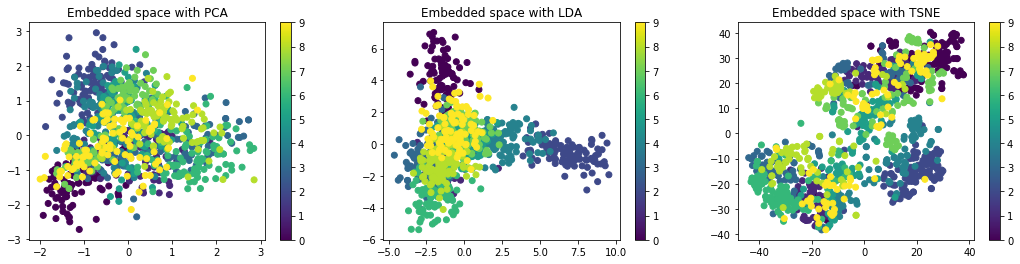

In [19]:
plt.figure(figsize=(18, 4))
plt.subplot(131)
plt.scatter(x_pca[:,0], x_pca[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with PCA")

plt.subplot(132)
plt.scatter(x_lda[:,0], x_lda[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with LDA")

plt.subplot(133)
plt.scatter(x_tsne[:,0], x_tsne[:,1], c=y)
plt.colorbar()
plt.title("Embedded space with TSNE")
plt.show()

## Classical Machine Learning

In [20]:
# Helper to plot confusion matrix -- from Scikit-learn website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Logistic Regression

In [22]:
params = {
    "cls__penalty": ["l1", "l2"],
    "cls__C": [0.5, 1, 2, 5],
    "cls__max_iter": [500]
}

pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', LogisticRegression())
])

grid_lr = GridSearchCV(pipe_lr, params, scoring='accuracy', n_jobs=6, cv=5)
grid_lr.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_t...
                                     

In [29]:
preds = grid_lr.predict(X_test)
print("Logistic Regression accuracy = {:.4f}".format(accuracy_score(y_test, preds)))

Logistic Regression accuracy = 0.6920


### SVM

In [24]:
params = {
    "cls__C": [0.5, 1, 2, 5],
    "cls__kernel": ['rbf', 'linear', 'sigmoid'],
}

pipe_svm = Pipeline([
    ('scale', StandardScaler()),
    ('var_tresh', VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ('feature_selection', SelectFromModel(lgbm.LGBMClassifier())),
    ('cls', SVC())
])

grid_svm = GridSearchCV(pipe_svm, params, scoring='accuracy', n_jobs=6, cv=5)
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('scale',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('var_tresh',
                                        VarianceThreshold(threshold=0.15999999999999998)),
                                       ('feature_selection',
                                        SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                                                 class_weight=None,
                                                                                 colsample_bytree=1.0,
                                                                                 importance_t...
                                     

In [27]:
preds = grid_svm.predict(X_test)
print("SVM accuracy = {:.4f}".format(accuracy_score(y_test, preds)))

SVM accuracy = 0.7740
